In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.segmentation import mark_boundaries
from scipy import ndimage as ndi
import pandas as pd
import json
import os
import timeit
import random

In [2]:
def ShowImage(ImageList, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):
    from matplotlib import pyplot as plt
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(nRows, nCols)
    gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.
    plt.figure(figsize=(20,20))
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        
        plt.subplot(nRows, nCols,i+1)
        
        image = ImageList[i].copy()
        if (len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)
        plt.title("Image " + str(i))
        plt.axis('off')
    plt.show()
    
def morphology(Mask, Size):
    from skimage.morphology import erosion, dilation, opening, closing, white_tophat
    from skimage.morphology import disk
    selem = disk(abs(Size))
    if(Size > 0):
        result = dilation(Mask, selem)
    else:
        result = erosion(Mask, selem)
    return result

import os
import pandas as pd
def get_subfiles(dir):
    "Get a list of immediate subfiles"
    return next(os.walk(dir))[2]

def SegmentColorImageByMask(IM, Mask):
    Mask = Mask.astype(np.uint8)
    result = cv2.bitwise_and(IM, IM, mask = Mask)
    return result

def SegmentationByOtsu(image, mask):
    image_process = image.copy()
    image_mask = mask.copy()
    image_process[image_mask == 0] = 0
    ListPixel = image_process.ravel()
    ListPixel = ListPixel[ListPixel > 0]
    from skimage.filters import threshold_otsu
    otsu_thresh = threshold_otsu(ListPixel)
    return otsu_thresh


def ResizeImage(IM, DesiredWidth, DesiredHeight):
    from skimage.transform import rescale, resize
    OrigWidth = float(IM.shape[1])
    OrigHeight = float(IM.shape[0])
    Width = DesiredWidth
    Height = DesiredHeight
    
    if((Width == 0) & (Height == 0)):
        return IM
    
    if(Width == 0):
        Width = int((OrigWidth * Height)/OrigHeight)
    
    if(Height == 0):
        Height = int((OrigHeight * Width)/OrigWidth)
    
    dim = (Width, Height)
    # print(dim)
    resizedIM = cv2.resize(IM, dim, interpolation = cv2.INTER_NEAREST)
    # imshows([IM, resizedIM], ["Image", "resizedIM"],1,2)
    return resizedIM


def SegmentByKmeans(image_orig, nClusters = 3):
    img = image_orig.copy()
    Z = img.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
    K = nClusters
    ret,labellist,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[labellist.flatten()]
    res2 = res.reshape((img.shape))
    label2 = labellist.reshape((img.shape[:2]))
    image_index = label2
    image_kmeans = res2
    # Sort to make sure the index is stable
    AreaList = []
    for idx in range(image_index.max() + 1):
        mask = image_index == idx
        AreaList.append(mask.sum().sum())
    sort_index = np.argsort(AreaList)[::-1]
    index = 0
    image_index1 = image_index * 0
    for idx in sort_index:
        image_index1[image_index == idx] = index
        index = index + 1
    image_index = image_index1.copy()
    return image_index, image_kmeans



def LabelObjectByMask(image_orig, image_mask, type = "BBox", color = (0,255,0), thick = 2):
    image_input = image_orig.copy()
    image_output = image_input.copy()
    
    label_img = label(image_mask)
    regions = regionprops(label_img)
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        left_top = (minc, minr)
        right_bottom = (maxc, maxr)
        at_row, at_col = props.centroid
        
        if(type == "Center"):
            cv2.drawMarker(image_output, (int(at_col), int(at_row)),color, markerType=cv2.MARKER_STAR, markerSize=15, thickness= 1, line_type=cv2.LINE_AA)
        if(type == "BBox"):
            cv2.rectangle(image_output,left_top, right_bottom, color ,thick)
    if(type == "Boundary"):
        color = [(number / 255) for number in color]
        image_mask = morphology(image_mask, 1)
        image_output = mark_boundaries(image_output, image_mask, color = color, mode='thick')
    if(type == "Fill"):
        image_output[image_mask > 0] = color
    return image_output


def SelectMaskByThreshArea(Mask, minArea = 300, maxArea = 100000):
    import pandas as pd
    from skimage.measure import label, regionprops
    
    mask = Mask.copy()
    mask_output = mask * 0
    bboxList = []
    
    label_img = label(mask)
    regions = regionprops(label_img)
    for props in regions:
        area = props.area
        label = props.label
        if((area > minArea) and (area < maxArea)):
            mask_output = mask_output + (label_img == label).astype(int)
    return mask_output



DataPath = "Lab06 - Image/"
path = DataPath
all_names = get_subfiles(path)

print("Number of Images:", len(all_names))
IMG = []
for i in range(len(all_names)):
    tmp = cv2.imread(path + all_names[i])
    IMG.append(tmp)
SegDataIMG = IMG.copy()
SegDataName = all_names


Number of Images: 60


# test

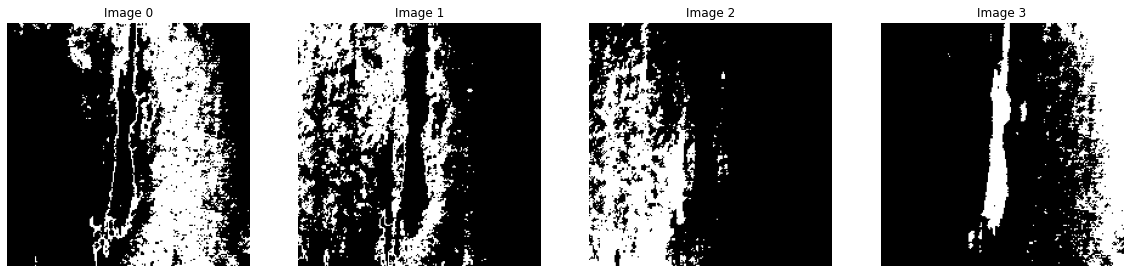

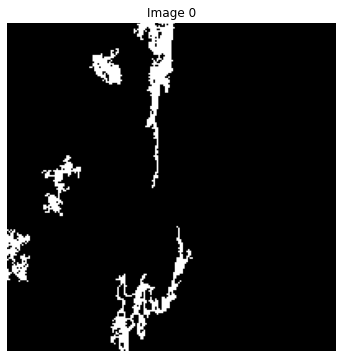

In [8]:
FileName = 'DefectA 01.bmp'
idx = SegDataName.index(FileName)
image = SegDataIMG[idx]
image_orig = ResizeImage(image, DesiredWidth = 0, DesiredHeight = 350)
image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
image_index, image_kmeans = SegmentByKmeans(image_orig, nClusters = 4) # Chọn số cluster để tách vật thể ra cảnh nền
# ShowImage([image_orig, image_index, image_kmeans], 1, 3)
mask_list = []
mask_abnormal = image_gray * 0
for idx in range(image_index.max() + 1):
    imask = image_index == idx
    mask_small = SelectMaskByThreshArea(imask, minArea = 200, maxArea = 1000)
    mask_list.append(imask)
    mask_abnormal = mask_abnormal + mask_small
ShowImage(mask_list, 1, len(mask_list))
ShowImage([mask_abnormal], 1, 3)



# Chọn cái nào segment đc cái vết  (image 3)

[[1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]]
[[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]]
[[0 0 0 ... 3 3 3]
 [0 0 0 ... 3 3 3]
 [0 0 0 ... 3 3 3]
 ...
 [0 0 0 ... 3 3 3]
 [0 0 0 ... 3 3 3]
 [0 0 0 ... 3 3 3]]
1906


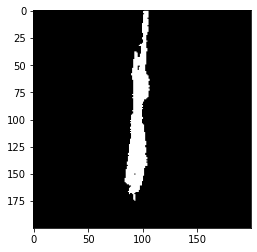

In [7]:

imask = image_index == 3   # chọn ảnh 3 như trên

label_img = label(imask)

regions = regionprops(label_img, intensity_image = image_hsv[:,:,0])
for props in regions:
        area = props.area
        ilabel = props.label
        imask = label_img == ilabel
        if area > 1900 and area < 2000:
            print(area)      # in ra diện tích của vết 
            plt.imshow(imask, cmap = plt.cm.gray)
            plt.show()

# CODE

Selected Image :  
Index  2 
Name  DefectA 01.bmp


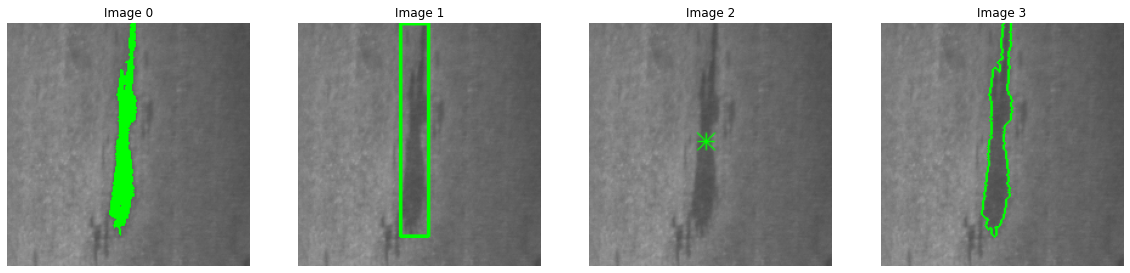

In [5]:


FileName = 'DefectA 01.bmp'
idx = SegDataName.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", SegDataName[idx])
image = SegDataIMG[idx]
image_orig = ResizeImage(image, DesiredWidth = 0, DesiredHeight = 350)
image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)


h = image_hsv[:,:,0]
s = image_hsv[:,:,1]
v = image_hsv[:,:,2]
y = image_ycbcr[:,:,0]
cb = image_ycbcr[:,:,1]
cr = image_ycbcr[:,:,2]


image_index, image_kmeans = SegmentByKmeans(image_orig, nClusters = 4)

mask_list = []
mask_abnormal = image_gray * 0
for idx in range(image_index.max() + 1):
    imask = image_index == idx
    mask_small = SelectMaskByThreshArea(imask, minArea = 0, maxArea = 2000)
    mask_list.append(imask)
    mask_abnormal = mask_abnormal + mask_small

imask = image_index == 3
label_img = label(imask)
regions = regionprops(label_img, intensity_image = image_hsv[:,:,0])

mask_condition1 = mask_abnormal * 0
mask_condition2 = mask_abnormal * 0
for props in regions:
    area = props.area
    ilabel = props.label
    imask = label_img == ilabel
    imean = props.mean_intensity
    imax = props.max_intensity
    imin = props.min_intensity
    condition1 = (area > 1900) and (area < 2000) and (imean < 70)

    if(condition1):
        mask_condition1 = mask_condition1 + (imask).astype(int)

image_output1 = LabelObjectByMask(image_orig, mask_condition1, type = "Fill", color = (0,255,0), thick = 2)
image_output2 = LabelObjectByMask(image_orig, mask_condition1, type = "BBox", color = (0,255,0), thick = 2)
image_output3 = LabelObjectByMask(image_orig, mask_condition1, type = "Center", color = (0,255,0), thick = 2)
image_output4 = LabelObjectByMask(image_orig, mask_condition1, type = "Boundary", color = (0,255,0), thick =
2)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)


